In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats
from collections import Counter

In [ ]:
def ideal_gas_law():
    """This was our first attempt at finding the distribution of temperatures based
    on the Ideal Gas Law. This was an unsuccesful attempt and we later found a paper
    that gave an application of this equation specific to popcorn."""
    P = np.random.normal(930792, 300)
    V = np.random.normal(44,2)*(1e-6)
    R = 8.31446261815324
    eta = np.random.normal(1.3e-2, 1e-6)
    T_target = (P*V)/(R*eta)
    return T_target

def ODE(T_b,T_0,r,t):
    #gives temperature at specified time
    T = lambda T_b, T_0, r, t: T_b + (T_0 - T_b)*np.exp(-r*t)
    results = []
    for i in t:
        results.append(T(T_b, T_0, r, i))
    return results

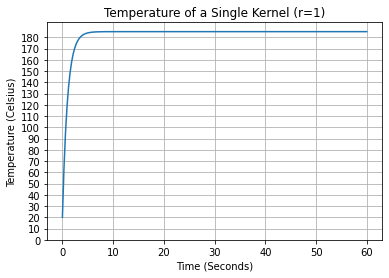

In [ ]:
"""This code was used to create the first couple plots in section 2.1 by using the
solution to Newton's Law of Cooling ODE above."""

T_b = 185   #temperature of the stove
T_0 = 20    #room temperature
r = 1
t = np.linspace(0,60,200)

results = ODE(T_b,T_0,r,t)

plt.plot(t, results)
plt.title("Temperature of a Single Kernel (r=1)")
plt.xlabel("Time (Seconds)")
plt.ylabel("Temperature (Celsius)")
plt.grid()
plt.yticks(np.arange(0,190,10))
plt.show()

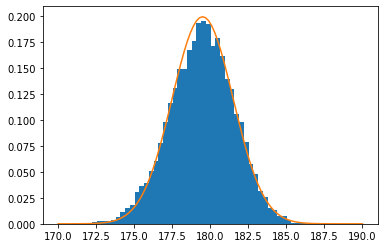

In [ ]:
##Code to draw from temperature distribution

draw = scipy.stats.norm.rvs(loc=10, scale = .5, size = 10000) #drawing the critical pressures

def temperature(pressure): #turn into critical temperatures
    return 373.15/(1-((8.3*373.15)/(18*2257))*np.log(pressure))-273.15

plt.hist(temperature(draw), density=True, bins = 50)
x = np.linspace(170,190,100)
plt.plot(x, scipy.stats.norm.pdf(x,loc=179.5, scale=2))
plt.show()


In [ ]:
def best_time(U): 
    """Return the best time given a model
        Parameters:
            U - 2-d array where each row corresponds to the status of the kernels at time t
        Returns:
            best_t (float) Optimal time according to our loss function
            best_u (int) Number of unpopped kernels at Optimal Time
            best_p (int) Number of popped kernels at Optimal Time
            best_b (int) Number of burnt kernels at Optimal Time
            currentloss (float) value of loss at Optimal Time
    """
    #initialize values
    best_t = 0
    best_u = 0
    best_p = 0
    best_b = 0
    currentloss = 1e10
    
    
    def loss(u,b,p): #define loss function
        eps = 1e-5 # incase there is a 0 in the log
        return -np.log(1-b+eps) -np.log(1-u+eps)/4 - np.log(p+eps)
    
    for t,row in enumerate(U):
        counts = Counter(row) #get counts for u, p , b
        counts  = dict(counts) #turn into dictionary
        #might not be any in a certain stage at a time, so set to 0
        if 'u' not in counts.keys():
            counts['u'] = 0
        if 'b' not in counts.keys():
            counts['b'] = 0
        if 'p' not in counts.keys():
            counts['p'] = 0
        #calculate loss based on proporation
        newloss = loss(counts['u']/len(row),counts['b']/len(row),counts['p']/len(row))
        
        if newloss < currentloss: #reset values
            best_t = t
            currentloss = newloss
            best_u = counts['u']
            best_p = counts['p']
            best_b = counts['b']
            
    return best_t,best_u,best_p,best_b, currentloss

In [ ]:
def plot_plate(U,t_space,ax,title = "Popping"):
    """Return the 
        Parameters:
            U - 2-d array where each row corresponds to the status of the kernels at time t
            t_space - time steps corresponding to U
            ax - axis from figure to pass in and return
            title - title for plot
        Returns:
            best_t (float) Optimal time according to our loss function
            u (int) Number of unpopped kernels at Optimal Time
            p (int) Number of popped kernels at Optimal Time
            b (int) Number of burnt kernels at Optimal Time
            currentloss (float) value of loss at Optimal Time
            ax - For plotting
    """
    
    colors = {"b":"black","p":"gold","u":"darkgoldenrod"} #color scheme for kernels
    markers = {"b":"H","p":"H","u":"o"} #marker scheme
    names = {"b":"Burned","p":"Popped","u":"Unpopped"} #names scheme
    ss = {"b":500,"p":500,"u":200} #marker scheme
    
    t,u,p,b,l = best_time(U) # call best_time()
    model = U[t] #get best row of U
    
    counts = Counter(model) #get counts of U, P ,B and turn into dict
    counts  = dict(counts)
    
    
    for i, corn in enumerate(counts.keys()): #iterate through dict
        #assign kernels to place in plot
        x = np.random.random(counts[corn])
        y = np.random.random(counts[corn])
        #plot
  
        ax.scatter(x,y,marker = markers[corn],color = colors[corn],label = names[corn],s = ss[corn])
        
    ax.legend(markerscale=.5,loc = 'upper right')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
        
    return t_space[t],u,p,b,l,ax  
    
    
    
    

In [ ]:
def model_kernel(num_kernel, T_s, T_0, r , t_step, burn_function, tau, c):
    """Return the status of each kernel at each time step and the time steps
        Parameters:
            num_kernel    (int): the number of kernels on the stove
            T_s           (float): the temperature of the stove
            T_0           (float): the initial temperature of the kernel (room temperature)
            r             (float): constant for the Newton’s Law of Cooling
            t_step        (int): the number of time steps to check the kereal status
            burn_function (int, 1 or 2): 1: use the first burn function. 2: use the second
            tau           (float): constant for the second burn function
            c             (float): constant for the second burn function
            
        Returns:
            states        ((t_step, num_kernel) list): the status of the kernel at each time step
            T             ((t-step), ndarray): all the time steps
    """
    # randomly draw from the popping temperature distribution
    pop_temp = np.random.normal(loc=179.4, scale=2, size=num_kernel)
    
    # use Newton’s Law of Cooling to calculate the exact time it takes to pop 
    # based on their popping temperature
    def time(temperature,T_s,r):
        return -np.log((temperature - T_s)/(T_0 - T_s))/r
   
    pop_time = time(pop_temp,T_s,r)
    
    # check if the popping temperature if greater than the stove temperature
    mask = np.isnan(pop_time)
    pop_time[mask] = 0
    # take the maximum pop time
    last_pop_t = np.max(pop_time)
    # set the ones that have popping temperature greater than the stove temperature
    # to infinity so they will never pop
    pop_time[mask] = np.inf
    # take the minimum pop time
    first_pop_t = np.min(pop_time)
   
    # the first burn function
    if burn_function == 1:
        # initialize the burn function
        c = 185*5.5
        burn_t = lambda T_s: c*np.exp(-T_s/(T_0*2))
        # get the time it takes to burn the popcorns after the fisrt pop
        burn_after_pop = burn_t(T_s)
        # time steps
        T = np.linspace(first_pop_t - burn_after_pop, last_pop_t + burn_after_pop, t_step)
        states = []
        # loop through all the time steps
        for t in T:
            U = []
            # compare the time with their popping time and burning time to get status
            for i,p in enumerate(pop_time):
                if p + burn_after_pop > t >= p:
                    U.append('p')
                elif t >= p + burn_after_pop:
                    U.append('b')
                else:
                    U.append('u')
            states.append(U)

        return states, T
    
    # second burning function
    elif burn_function == 2:
        # initializing the second burn function
        burn_t = lambda num_pop: 185*5*np.exp(-T_s/(T_0*2)) + c*(tau-num_pop/num_kernel)
       
        # time steps
        T = np.linspace(first_pop_t - 10, last_pop_t + 10, t_step)
        # initializing
        states = []
        popped_or_burned = 0
        # loop through all the time steps
        for t in T:
            U = []
            # calculating the burn time after pop time based on the number of popped
            burn_after_pop = burn_t(popped_or_burned)
            # loop through all the kernel and get the status based on the time
            for i,p in enumerate(pop_time):
                if p + burn_after_pop > t and t >= p:
                    U.append('p')
                elif t >= p + burn_after_pop:
                    U.append('b')
                else:
                    U.append('u')
            # get the number of popped or burnt
            popped_or_burned = U.count('p') + U.count('b')
            states.append(U)
            
        return states, T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


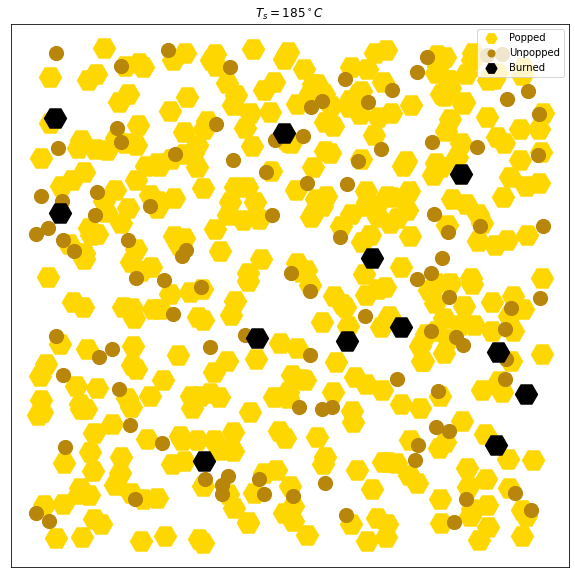

In [ ]:
U1,t_space1 = model_kernel(500,185,20,.05,100,2,1,30)

fig, ax1 = plt.subplots(1,figsize =(10,10) )
t1,u1,p1,b1,l1,ax1= plot_plate(U1,t_space1,ax = ax1,title = r"$T_s = 185^\circ C$")